# ADFA-LD - Logistic Regression 

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
import statistics
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

In [2]:
import glob
import math
from collections import Counter
import csv

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
# returns a dictionary of n-grams frequency for any list
def ngrams_freq(listname, n):
    counts = dict()
    # make n-grams as string iteratively
    grams = [' '.join(listname[i:i+n]) for i in range(len(listname)-n)]
    for gram in grams:
        if gram not in counts:
            counts[gram] = 1
        else:
            counts[gram] += 1
    return counts

# returns the values of features for any list
def feature_freq(listname,n,features):
	counts = dict()
	# make n-grams as string iteratively
	grams = [' '.join(listname[i:i+n]) for i in range(len(listname)-n)]
	for gram in grams:
		counts[gram] = 0
	for gram in grams:
		if gram in features:
			counts[gram] += 1
	return counts

# values of n for finding n-grams
n_values = [1]

# Base address for attack data files
add = "ADFA-LD/ADFA-LD/Attack_Data_Master/"
# list of attacks
attack = ['Adduser','Hydra_FTP','Hydra_SSH','Java_Meterpreter','Meterpreter','Web_Shell']

# initializing dictionary for n-grams from all files
traindict = {}

Attack_list_new = []
print("Generating Training Data ..................................")
for term in attack:
	print("	Training data from " + term)
	globals()['%s_list' % term] = []
	in_address = add+term
	k = 1
	# finding list of data from all files
	for i in range (1,11):
		read_files = glob.glob(in_address+"_"+str(i)+"/*.txt")
		for f in read_files:
			with open(f, "r") as infile:
				globals()['%s_list_array' % term+str(k)] = ALine =infile.read()
				#ALine = ALine[:820]                
				Attack_list_new.append(term +','+ str(ALine))
				globals()['%s_list' % term].extend(globals()['%s_list_array' % term+str(k)])
				k += 1
	# number of lists for distinct files
	globals()['%s_size' % term] = k-1
	# combined list of all files
	listname = globals()['%s_list' % term]
	# finding n-grams and extracting top 30%
	for n in n_values:
		#print("		Extracting top 30% "+str(n)+"-grams from "+term+".......................")
		dictname = ngrams_freq(listname,n)
		top = math.ceil(0.3*len(dictname))
		dictname = Counter(dictname)
		for k, v in dictname.most_common(top):
			traindict.update({k : v})

# finding training data for Normal file
print("	Training data from Normal")
Normal_list = []
Normal_list_new = []
in_address = "ADFA-LD/ADFA-LD/Training_Data_Master/"
k = 1
read_files = glob.glob(in_address+"/*.txt")
for f in read_files:
	with open(f, "r") as infile:
		globals()['Normal%s_list_array' % str(k)] = Line = infile.read()
		Normal_list_new.append('Normal,'+ str(Line))
		Normal_list.extend(globals()['Normal%s_list_array' % str(k)])
		k += 1

# number of lists for distinct files
Normal_list_size = k-1
# combined list of all files
listname = Normal_list


print("\nnew_train.csv created..............................................\n")


Generating Training Data ..................................
	Training data from Adduser
	Training data from Hydra_FTP
	Training data from Hydra_SSH
	Training data from Java_Meterpreter
	Training data from Meterpreter
	Training data from Web_Shell
	Training data from Normal

new_train.csv created..............................................



In [3]:
new_train_list = []
new_train_list = Normal_list_new + Attack_list_new
#new_train_list[1]
#Attack_list_new[1]


In [4]:
new_train_list = []
new_train_list = Normal_list_new + Attack_list_new


with open('new_train.csv', 'w') as f:
    for item in new_train_list:
        f.write("%s\n" % item)       

In [5]:
train = pd.read_csv("./new_train.csv", sep=',',error_bad_lines=False, header=None, names=['Label','CallTrace'])
train.head(5)
train.shape
#train.info()

#train.describe(include = 'all')
train_df = train.copy()
train['Label'] = train['Label'].astype('category')
train['CallTrace'] = train['CallTrace'].astype('category')

train['Label'].value_counts()
#train['CallTrace'].value_counts()

Normal              833
Hydra_SSH           176
Hydra_FTP           162
Java_Meterpreter    124
Web_Shell           118
Adduser              91
Meterpreter          75
Name: Label, dtype: int64

In [6]:
train['Label_Codes'] = train['Label'].cat.codes
train['CallTrace_Codes'] = train['CallTrace'].cat.codes
train['Label_Codes'].value_counts()

5    833
2    176
1    162
3    124
6    118
0     91
4     75
Name: Label_Codes, dtype: int64

In [7]:
train.head()

,Label,CallTrace,Label_Codes,CallTrace_Codes
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...,5,1407
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...,5,1239
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...,5,1286
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...,5,1465
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...,5,93


# Multinominal Logistic Regression

In [8]:
import warnings
warnings.filterwarnings("ignore")

# split the dataset in train and test
X = train.iloc[:, [3]].values
y = train.iloc[:, 2].values


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(multi_class='ovr', solver = 'lbfgs')
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# How did our model perform?
from sklearn import metrics
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))




Misclassified samples: 145
Accuracy: 0.54


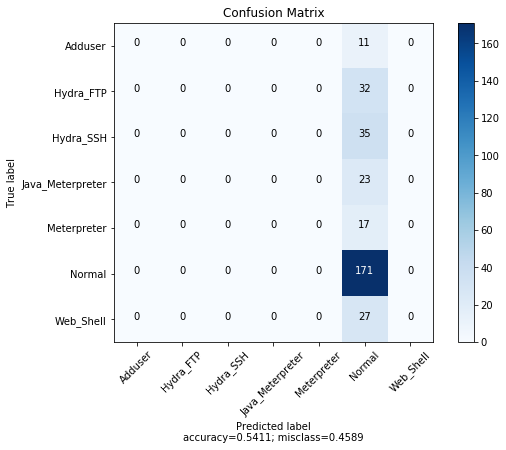

In [9]:
#classifier.predict_proba(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Adduser', 'Hydra_FTP', 'Hydra_SSH', 'Java_Meterpreter', 'Meterpreter', 'Normal', 'Web_Shell'],
                      title        = "Confusion Matrix")

# Logistic Regression Binary Classification

In [10]:
train.loc[train.Label != 'Normal','Label_Binary']= 1
train.loc[train.Label == 'Normal','Label_Binary']= 0
train['Label_Binary'].value_counts()
#train.head()

0.0    833
1.0    746
Name: Label_Binary, dtype: int64

In [11]:
train.head()

,Label,CallTrace,Label_Codes,CallTrace_Codes,Label_Binary
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...,5,1407,0.0
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...,5,1239,0.0
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...,5,1286,0.0
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...,5,1465,0.0
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...,5,93,0.0


In [12]:
import warnings
warnings.filterwarnings("ignore")

# split the dataset in train and test
X = train.iloc[:, [3]].values
y = train.iloc[:, 4].values


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
#classifier = LogisticRegression(multi_class='ovr', solver = 'lbfgs')
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# How did our model perform?
from sklearn import metrics
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))




Misclassified samples: 156
Accuracy: 0.51


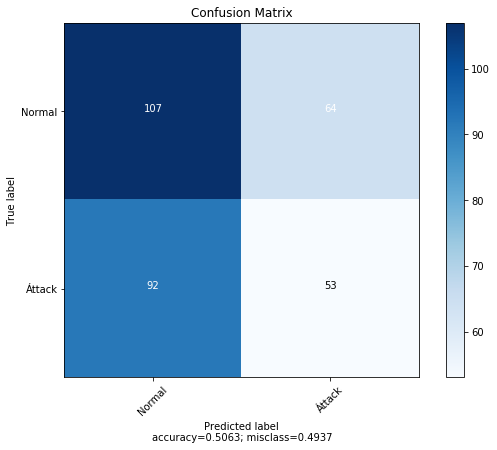

In [13]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Normal', 'Áttack'],
                      title        = "Confusion Matrix")

In [14]:
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.63      0.54      0.58       199
         1.0       0.37      0.45      0.40       117

   micro avg       0.51      0.51      0.51       316
   macro avg       0.50      0.50      0.49       316
weighted avg       0.53      0.51      0.51       316



# OneHotEncoding for LogisticRegression

In [15]:
# Split into predictor and response dataframes.
train_df_enc = train_df.copy()
X_df = train_df_enc.drop('Label', axis=1)
y = train_df_enc['Label']

X_df.shape,y.shape

((1579, 1), (1579,))

In [16]:
X_df.head()

,CallTrace
0,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...
1,54 175 120 175 175 3 175 175 120 175 120 175 1...
2,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...
3,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...
4,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...


In [17]:
train_df.head()

,Label,CallTrace
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...


In [18]:
# Map response variable to integers 0,1.
y = pd.Series(np.where(y.values != 'Normal',1,0), y.index)
y.value_counts()

0    833
1    746
dtype: int64

In [19]:
# Label Encode instead of dummy variables

mappings = []

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_df = train.drop('Label', axis=1)
label_df = train.drop('Label_Binary', axis=1)
label_df = train.drop('Label_Codes', axis=1)
label_df['CallTrace'] = label_df['CallTrace_Codes']
label_df = X_df.copy()
for i, col in enumerate(label_df):
    if label_df[col].dtype == 'object':
        label_df[col] = label_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

In [20]:
label_df.head()

,CallTrace
0,1407
1,1239
2,1286
3,1465
4,93


In [21]:
from sklearn.preprocessing import OneHotEncoder


onehot_encoder = OneHotEncoder()
for i, col in enumerate(label_df):
    if label_df[col].dtype == 'object':
        label_df[col] = onehot_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(onehot_encoder.classes_, range(1, len(onehot_encoder.classes_)+1))))

In [22]:
 label_df[col].head()

0    1407
1    1239
2    1286
3    1465
4      93
Name: CallTrace, dtype: int32

In [23]:
X_train, X_test, y_train, y_test = train_test_split(label_df, y, test_size = 0.2, random_state = 10)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1263, 1), (316, 1), (1263,), (316,))

In [24]:
clf = LogisticRegression()
model_mix = clf.fit(X_train, y_train)
# y_pred = model_norm.predict(X_test)
print("Model accuracy is", model_mix.score(X_test, y_test))

Model accuracy is 0.5569620253164557


In [25]:
model_mix

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
# logit_roc_auc = roc_auc_score(y_test, model_norm.predict(X_test))
# fpr, tpr, thresholds = roc_curve(y_test, model_norm.predict_proba(X_test)[:,1])

classes = model_mix.predict(X_test)
probs = model_mix.predict_proba(X_test)
preds = probs[:,1]
#preds

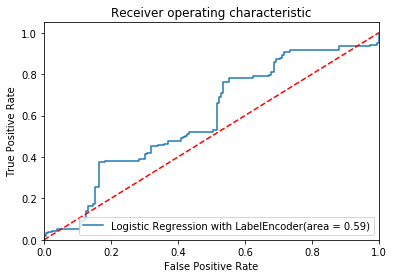

In [27]:
labelfpr, labeltpr, labelthreshold = metrics.roc_curve(y_test, preds)
label_roc_auc = metrics.auc(labelfpr, labeltpr)

plt.figure()
plt.plot(labelfpr, labeltpr, label='Logistic Regression with LabelEncoder(area = %0.2f)' % label_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

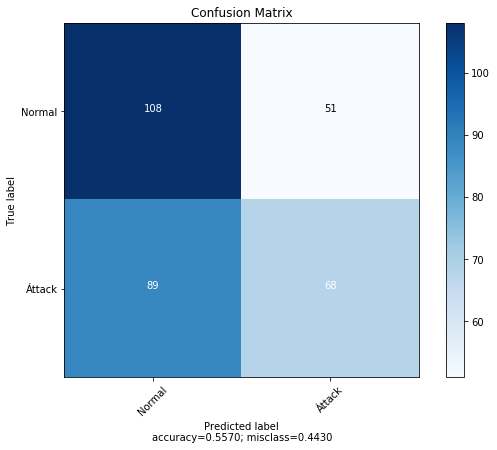

In [28]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, classes)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Normal', 'Áttack'],
                      title        = "Confusion Matrix")

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1263, 1), (316, 1), (1263,), (316,))

In [30]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.68      0.55      0.61       197
           1       0.43      0.57      0.49       119

   micro avg       0.56      0.56      0.56       316
   macro avg       0.56      0.56      0.55       316
weighted avg       0.59      0.56      0.56       316



# RandomForest Classification

In [31]:
# Normalize using MinMaxScaler to constrain values to between 0 and 1.
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
clf = RandomForestClassifier(n_jobs=-1)
model_rf = clf.fit(X_train, y_train)
print('Model accuracy is',model_rf.score(X_test, y_test))

Model accuracy is 0.8069620253164557


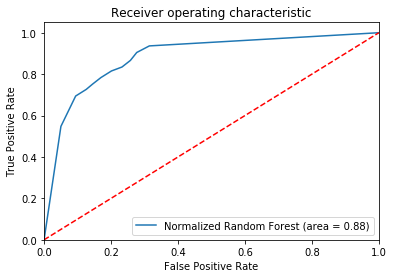

In [33]:
probs = model_rf.predict_proba(X_test)
preds = probs[:,1]
rffpr, rftpr, rfthreshold = metrics.roc_curve(y_test, preds)
rf_roc_auc = metrics.auc(rffpr, rftpr)

plt.figure()
plt.plot(rffpr, rftpr, label='Normalized Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

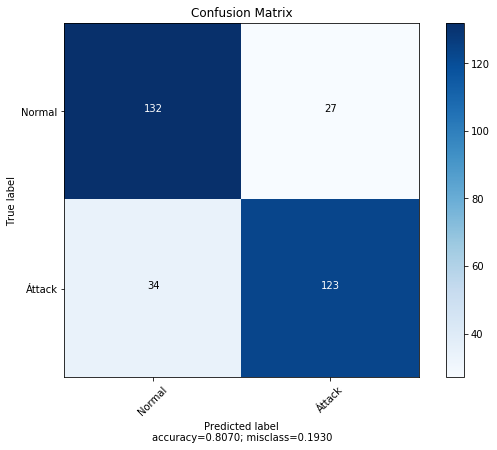

In [34]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
classes = model_rf.predict(X_test)
cm = confusion_matrix(y_test, classes)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Normal', 'Áttack'],
                      title        = "Confusion Matrix")

In [35]:
print(metrics.classification_report(classes, y_test))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81       166
           1       0.78      0.82      0.80       150

   micro avg       0.81      0.81      0.81       316
   macro avg       0.81      0.81      0.81       316
weighted avg       0.81      0.81      0.81       316



# Train Data with ngrams

In [36]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.1, 0.9],
    n_features=20, n_samples=1000, random_state=10
)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf = LogisticRegression(class_weight="balanced")
clf.fit(X_train, y_train)
THRESHOLD = 0.5
preds = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
             index=["accuracy", "recall", "precision", "roc_auc_score"])

,0
accuracy,0.531646
recall,0.579618
precision,0.526012
roc_auc_score,0.531947


In [37]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_y)

# load the dataset
#data = open('data/corpus').read()
#labels, texts = [], []
#for i, line in enumerate(data.split("\n")):
#    content = line.split()
#    labels.append(content[0])
#    texts.append(" ".join(content[1:]))

# create a dataframe using texts and lables
#trainDF = pandas.DataFrame()
#trainDF['text'] = texts
#trainDF['label'] = labels

Using TensorFlow backend.


In [38]:
X_df.head()

,CallTrace
0,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...
1,54 175 120 175 175 3 175 175 120 175 120 175 1...
2,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...
3,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...
4,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...


In [39]:
# create a dataframe using texts and lables
trainDF = train_df.copy()

trainDF['CallTrace_T'] = trainDF.CallTrace.str.split(' ').str.join(',').astype(str)
#X_df = trainDF.drop('Label', axis=1)
X_df = trainDF.drop(['Label', 'CallTrace'], axis=1)
y = trainDF['Label']

# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(X_df, y)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

X_df.head()
#list(encoder.classes_)
#le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
#print(le_name_mapping)

,CallTrace_T
0,"6,6,63,6,42,120,6,195,120,6,6,114,114,1,1,252,..."
1,"54,175,120,175,175,3,175,175,120,175,120,175,1..."
2,"6,11,45,33,192,33,5,197,192,6,33,5,3,197,192,1..."
3,"7,174,174,5,197,197,6,13,195,4,4,118,6,91,38,5..."
4,"11,45,33,192,33,5,197,192,6,33,5,3,197,192,192..."


In [40]:
train_x.shape, valid_x.shape, train_y.shape, valid_y.shape

((1184, 1), (395, 1), (1184,), (395,))

In [41]:
trainDF.head()

,Label,CallTrace,CallTrace_T
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...,"6,6,63,6,42,120,6,195,120,6,6,114,114,1,1,252,..."
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...,"54,175,120,175,175,3,175,175,120,175,120,175,1..."
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...,"6,11,45,33,192,33,5,197,192,6,33,5,3,197,192,1..."
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...,"7,174,174,5,197,197,6,13,195,4,4,118,6,91,38,5..."
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...,"11,45,33,192,33,5,197,192,6,33,5,3,197,192,192..."


## Feature Engineering - 1n, 2n, 3n-grams


In [42]:
trainDF.head()

,Label,CallTrace,CallTrace_T
0,Normal,6 6 63 6 42 120 6 195 120 6 6 114 114 1 1 252 ...,"6,6,63,6,42,120,6,195,120,6,6,114,114,1,1,252,..."
1,Normal,54 175 120 175 175 3 175 175 120 175 120 175 1...,"54,175,120,175,175,3,175,175,120,175,120,175,1..."
2,Normal,6 11 45 33 192 33 5 197 192 6 33 5 3 197 192 1...,"6,11,45,33,192,33,5,197,192,6,33,5,3,197,192,1..."
3,Normal,7 174 174 5 197 197 6 13 195 4 4 118 6 91 38 5...,"7,174,174,5,197,197,6,13,195,4,4,118,6,91,38,5..."
4,Normal,11 45 33 192 33 5 197 192 6 33 5 3 197 192 192...,"11,45,33,192,33,5,197,192,6,33,5,3,197,192,192..."


In [43]:
train_1n = pd.read_csv("./train_1n.csv")
train_1n.columns
train_1n_bkp = train_1n.copy()
train_1n.head()

,Label,168,265,3,54,162,142,309,146,114,175,43,104,5,78,102,13,6,240,4,192,195,91,85,125,197,140,19,174,301,221,33,180,45,196,120,7,220,42,63,11,1,252,201,243,199,308,122,118,219
0,Adduser,193,75,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adduser,0,110,139,0,0,286,0,55,0,64,0,50,0,0,0,0,0,0,0,3,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adduser,249,133,112,0,0,0,0,0,0,0,60,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adduser,0,1,51,809,0,0,202,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adduser,426,234,157,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
train_1n.columns

Index(['Label', '168', '265', '3', '54', '162', '142', '309', '146', '114',
       '175', '43', '104', '5', '78', '102', '13', '6', '240', '4', '192',
       '195', '91', '85', '125', '197', '140', '19', '174', '301', '221', '33',
       '180', '45', '196', '120', '7', '220', '42', '63', '11', '1', '252',
       '201', '243', '199', '308', '122', '118', '219'],
      dtype='object')

##  Modelling Logistic Regression - 1n-grams

In [76]:
import warnings
warnings.filterwarnings("ignore")

# split the dataset in train and test

#y = train_1n.iloc[:, 0].values
#train_1n_no_y = train_1n.drop('Label', axis=1)
#X = train_1n_no_y.iloc[:, :].values
y = train_1n.iloc[:, 0]
train_1n_no_y = train_1n.drop('Label', axis=1)
X = train_1n_no_y.iloc[:, :]


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)


In [77]:
X_test_bkp = X_test

In [78]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, type(X), type(y)

((1070, 49),
 (268, 49),
 (1070,),
 (268,),
 pandas.core.frame.DataFrame,
 pandas.core.series.Series)

In [79]:

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(multi_class='ovr', solver = 'lbfgs')
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# How did our model perform?
from sklearn import metrics
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))


Misclassified samples: 72
Accuracy: 0.73


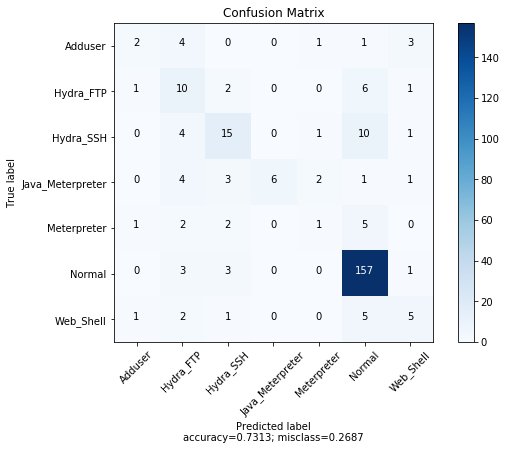

In [64]:
#classifier.predict_proba(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Adduser', 'Hydra_FTP', 'Hydra_SSH', 'Java_Meterpreter', 'Meterpreter', 'Normal', 'Web_Shell'],
                      title        = "Confusion Matrix")

In [80]:
y_pred.shape, y_test.shape, type(y_test)

((268,), (268,), pandas.core.series.Series)

In [81]:
# Merge predicted results into original dataframe
# y_test['preds'] = y_pred
# df_out = pd.merge(train_1n, y_test[['preds']], how = 'left', right_index = True)

In [82]:
train_1n.index

RangeIndex(start=0, stop=1338, step=1)

In [85]:
train_2n = pd.read_csv("./train_2n.csv")
train_2n.columns
train_2n_bkp = train_2n.copy()
train_2n.head() 

,Label,168 168,54 54,168 265,162 162,265 168,3 168,168 3,265 265,3 3,265 3,3 265,54 309,309 54,114 162,162 114,142 142,142 3,3 142,142 265,265 142,3 54,174 174,309 309,43 168,168 146,142 146,146 3,146 142,175 175,54 3,146 168,175 142,168 43,114 114,146 265,265 146,142 175,265 43,3 146,104 3,309 3,3 104,104 142,5 5,3 175,43 265,5 3,43 3,3 43,142 104,192 192,102 168,142 119,265 104,197 192,146 146,119 142,168 102,175 3,192 6,43 43,104 265,3 197,33 5,125 125,3 5,6 33,265 175,175 104,175 265,175 146,19 19,265 102,119 265,104 175,146 175,91 5,175 119,146 104,3 309,3 6,5 197,265 119,91 3,5 6,119 3,3 91,78 78,142 78,78 142,78 102,78 13,102 102,240 240,13 13,13 78,13 4,102 78,4 78,240 13,102 142,309 102,78 146,102 309,146 78,85 195,142 102,102 27,6 125,265 240,195 85,4 240,4 4,240 4,13 240,5 102,6 5,102 5,6 91,5 192,13 265,102 6,102 13,195 5,192 3,102 265,78 240,6 78,6 142,102 195,4 13,240 78,195 78,142 6,78 4,27 85,78 6,10 102,27 102,102 85,85 85,6 102,4 265,91 91,125 91,13 102,27 5,5 309,309 5,196 102,85 102,125 3,221 221,5 91,91 195,91 6,195 102,168 78,27 309,78 168,6 6,78 195,309 27,196 196,195 175,195 195,195 3,3 195,3 192,192 5,195 196,5 140,5 195,175 5,6 27,175 195,27 174,7 7,142 195,309 85,102 146,265 4,192 125,6 3,195 142,265 13,3 78,146 102,196 265,265 10,240 265,125 195,125 5,197 3,5 33,78 3,309 195,102 196,102 10,85 265,85 196,125 268,45 45,140 91,142 4,197 5,5 27,140 197,85 309,13 142,195 265,27 27,192 140,4 142,268 5,142 13,6 195,6 196,192 33,6 309,10 309,85 10,78 265,195 6,221 3,174 6,5 13,102 221,104 104,3 13,199 5,174 27,4 3,6 192,13 199,3 4,33 192,140 27,265 78,102 3,3 102,6 265,91 102,3 221,27 221,265 5,221 27,33 6,102 91,13 5,265 54,6 199,195 340,43 195,27 6,5 125,199 201,91 142,340 3,63 63,6 168,140 78,78 140,78 196,196 78,140 3,78 125,146 163,125 78,163 146,219 219,78 192,78 5,3 140,192 78,5 78,140 140,195 140,196 195,120 240,240 102,125 240,102 240,33 33,33 195,104 146,3 125,265 340,78 33,78 120,340 168,265 195,119 146,192 240,3 19,19 3,168 340,3 33,340 265,33 3,175 54,168 195,33 4,119 175,175 174,301 301,220 301,301 220,195 33,221 301,301 300,4 168,301 221,33 13,196 33,195 91,13 33,168 4,301 6,300 301,6 301,102 192,78 104,168 91,7 142,168 45,196 5,33 196,196 91,5 196,197 91,19 168,142 7,195 168,91 45,102 45,91 192,168 19,301 295,192 168,104 13,45 78,192 91,295 301,54 265,104 91,168 192,91 196,13 196,220 220,197 197,45 192,197 6,180 180,240 196,3 45,45 3,5 221,120 6,63 6,6 221,42 120,54 140,1 1,120 114,221 197,140 4,174 175,11 45,45 33,140 6,221 6,5 220,196 240,4 6,120 175,243 125,42 221,4 140,192 243,252 252,5 54,168 42,175 120,220 5,45 5,6 45,221 63,5 4,221 168,308 3,4 7,7 3,45 175,7 308,125 192,168 54,168 240,4 5,220 6,7 175,45 195,195 120,120 3,6 4,265 221,118 6,311 240,221 265,4 175,175 4,45 6,6 63,175 7,54 102,175 45,195 4,102 4,13 195,240 3,6 11,3 7,45 91,195 13,197 140,11 11,6 174,3 240,4 221,114 120,220 195,240 174,33 197,258 311,175 191,191 122,197 221,192 4,91 33,5 45,180 125,91 258,6 54,6 175,221 142,125 180,240 168,195 197,6 114,3 120,140 195,4 195,221 220,6 197,6 7,195 220,6 120,5 175,6 42,174 3,221 4,195 201,114 63,265 140,195 45,5 63,221 33,195 42,331 4,162 3,197 195,196 3,3 176,176 162,114 195,7 119,120 7,240 5,175 42,174 7,91 4,13 175,221 102,114 5,192 195,54 175,195 192,256 265,162 195,240 6,168 7,175 162,5 120,3 196,78 180,4 120,120 120,6 240,221 140,114 42,174 11,197 33,5 141,6 13,158 158,78 219,91 78,140 221,201 202,7 174,4 118,174 45,141 141,141 6,199 102,197 220,42 42,168 6,4 102,4 63,309 265,175 6,140 54,63 120,255 255,240 180,197 45,180 240,4 33,265 256,265 309,91 38,91 197,221 174,180 78,19 196,221 5,192 45,6 140,221 240,45 140,45 64,78 175,199 200,268 45,38 5,5 118,160 159,33 78,192 197,4 91,221 120,45 4,195 54,63 221,54 195,195 174,174 195,4 197,221 195,220 221,197 4,42 168,91 174,140 120,200 33,33 125,311 78,4 174,54 5,240 221,45 168,202 199,196 19,1 252,91 240,252 1,240 33,3 42,54 6,4 331,122 268,140 5,196 85,119 174,201 45,122 45,221 42,168 5,125 45,174 201,221 199,6 10,42 54,168 

In [87]:
train_3n = pd.read_csv("./train_3n.csv")
train_3n.columns
train_3n_bkp = train_3n.copy()
train_3n.head() 

Label  168 168 168  54 54 54  162 162 162  168 265 168  265 168 168  \
0  Adduser          101         0            0           31           34   
1  Adduser            0         0            0            0            0   
2  Adduser           49         0            0           25           26   
3  Adduser            0       431            0            0            0   
4  Adduser          132         0            0           63           68   

   168 168 265  168 3 168  168 168 3  3 168 168  54 309 54  54 54 309  \
0           31          0          0          0          0          0   
1            0          0          0          0          0          0   
2           25         22         23         21          0          0   
3            0          0          0          0        137        128   
4           60         33         42         36          0          0   

   265 168 265  309 54 54  168 265 265  265 265 168  162 114 162  114 162 162  \
0           12          0           14           14            0            0   
1            0          0            0            0            0            0   
2           12          0           11           14            0            0   
3            0        124            0            0            0            0   
4           32          0           32           31            0            0   

   162 162 114  3 168 265  168 265 3  265 3 168  3 265 168  265 168 3  \
0            0          0          0          0          0          0   
1            0          0          0          0          0          0   
2            0         11         14         15         12         14   
3            0          0          0          0          0          0   
4            0         24         22         16         25         19   

   168 3 265  265 265 265  3 168 3  3 3 168  168 3 3  3 3 3  265 3 265  \
0          0            9        0        0        0      0          0   
1          0            8        0        0        0     18          3   
2         15            8        9        9        7      2          9   
3          0            0        0        0        0      0          0   
4         18           25        9       18       18      7         17   

   265 265 3  174 174 174  265 3 3  3 265 3  3 265 265  309 54 309  3 54 54  \
0          0            0        0        0          0           0        0   
1          4            0        5        5          2           0        0   
2          5            0        5        7          7           0        0   
3          0            0        0        0          0          37       37   
4         13            0       13       11         12           0        0   

   3 3 265  142 142 142  54 309 309  114 162 114  54 3 54  114 114 162  \
0        0            0           0            0        0            0   
1        5           60           0            0        0            0   
2        2            0           0            0        0            0   
3        0            0          26            0       38            0   
4       13            0           0            0        0            0   

   309 309 54  54 54 3  162 114 114  309 3 54  142 142 3  168 146 168  \
0           0        0            0         0          0            0   
1           0        0            0         0         14            0   
2           0        0            0         0          0            0   
3          24       33            0         9          0            0   
4           0        0            0         0          0            0   

   54 309 3  265 142 142  175 175 175  142 142 265  43 168 168  3 142 142  \
0         0            0            0            0           0          0   
1         0           14            7           19           0         14   
2         0            0            0            0          12          0   
3         8            0            0            0           0         

In [88]:
train_1n.shape, train_2n.shape, train_3n.shape

((1338, 50), (1338, 800), (1338, 4148))

# Modelling Logistic Regression/SVM/RandomForrest - 1n-grams + 2n-grams + 3n-grams

In [91]:
frames=[train_1n, train_2n, train_3n]
result=pd.concat(frames, axis=1)
result.shape

(1338, 4998)

In [92]:
result.head()

Label  168  265    3   54  162  142  309  146  114  175  43  104  5  78  \
0  Adduser  193   75    0    0    0    0    0    0    0    0   0    0  0   0   
1  Adduser    0  110  139    0    0  286    0   55    0   64   0   50  0   0   
2  Adduser  249  133  112    0    0    0    0    0    0    0  60    0  0   0   
3  Adduser    0    1   51  809    0    0  202    0    0    0   0    0  0   0   
4  Adduser  426  234  157    0    0    0    0    0    0    0   0    0  0   2   

   102  13  6  240  4  192  195  91  85  125  197  140  19  174  301  221  33  \
0   10   0  0    0  0    0    0   0   0    0    0    0   0    0    0    0   0   
1    0   0  0    0  0    3    0   8   0    0    0    0   0    0    0    0   0   
2    0   0  0    0  0    0    4   0   0    0    0    0   0    0    0    0   0   
3    0   0  0    4  0    0    0   0   0    0    0    0   0    0    0    0   0   
4    0   0  0    0  0    0    0   0   0    0    0    1   0    0    0    0   0   

   180  45  196  120  7  220  42  63  11  1  252  201  243  199  308  122  \
0    0   0    0    0  0    0   0   0   0  0    0    0    0    0    0    0   
1    0   0    0    0  0    0   0   0   0  0    0    0    0    0    0    0   
2    0   0    0    0  0    0   0   0   0  0    0    0    0    0    0    0   
3    0   0    0    0  0    0   0   0   0  0    0    0    0    0    0    0   
4    0   0    0    0  0    0   0   0   0  0    0    0    0    0    0    0   

   118  219    Label  168 168  54 54  168 265  162 162  265 168  3 168  168 3  \
0    0    0  Adduser      138      0       48        0       47      0      0   
1    0    0  Adduser        0      0        0        0        0      0      0   
2    0    0  Adduser      110      0       60        0       55     48     52   
3    0    0  Adduser        0    594        0        0        0      0      0   
4    0    0  Adduser      236      0      117        0      119     69     71   

   265 265  3 3  265 3  3 265  54 309  309 54  114 162  162 114  142 142  \
0       24    0      0      0       0       0        0        0        0   
1       24   45     17     20       0       0        0        0      126   
2       28   16     31     32       0       0        0        0        0   
3        0    1      0      0     172     165        0        0        0   
4       69   38     46     48       0       0        0        0        0   

   142 3  3 142  142 265  265 142  3 54  174 174  309 309  43 168  168 146  \
0      0      0        0        0     0        0        0       0        0   
1     32     38       38       39     0        0        0       0        0   
2      0      0        0        0     0        0        0      30        0   
3      0      0        0        0    48        0       26       0        0   
4      0      0        0        0     0        0        0       0        0   

   142 146  146 3  146 142  175 175  54 3  146 168  175 142  168 43  114 114  \
0        0      0        0        0     0        0        0       0        0   
1       25     14       20       17     0        0       22       0        0   
2        0      0        0        0     0        0        0      18        0   
3        0      0        0        0    40        0        0       0        0   
4        0      0        0        0     0        0        0       0        0   

   146 265  265 146  142 175  265 43  3 146  104 3  309 3  3 104  104 142  \
0        0        0        0       0      0      0      0      0        0   
1        8       13       22       0      6     17      0     11       17   
2        0        0        0      19      0      0      0      0        0   
3        0        0        0       0      0      0     10      0        0   
4        0        0        0       0      0      0      0      0        0   

   5 5  3 175  43 265  5 3  43 3  3 43  142 104  192 192  102 168  142 119  \
0    0      0       0    0     0     0        0        0        8        0   
1    0     10       0    0     0     0       19        0     

In [128]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Columns: 4998 entries, Label to 85 196 5
dtypes: int64(4995), object(3)
memory usage: 51.0+ MB


In [98]:
import warnings
warnings.filterwarnings("ignore")

# split the dataset in train and test

y = result.iloc[:, 0].values
result_no_y = result.drop('Label', axis=1)
X = result_no_y.iloc[:, :].values

In [ ]:
result

In [99]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, type(X), type(y)

((1070, 4995), (268, 4995), (1070,), (268,), numpy.ndarray, numpy.ndarray)

In [130]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
#classifier = LogisticRegression(multi_class='ovr', solver = 'lbfgs')
#classifier = SVC(kernel = 'linear', random_state = 0)
#classifier = SVC(kernel = 'rbf', random_state = 0)
clf = RandomForestClassifier(n_jobs=-1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# How did our model perform?
from sklearn import metrics
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified samples: 52
Accuracy: 0.81


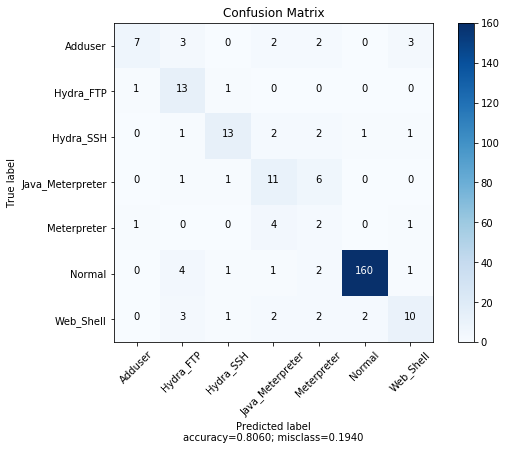

In [131]:
#classifier.predict_proba(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,  
                      normalize    = False,
                      target_names = ['Adduser', 'Hydra_FTP', 'Hydra_SSH', 'Java_Meterpreter', 'Meterpreter', 'Normal', 'Web_Shell'],
                      title        = "Confusion Matrix")

## Applying 10-Fold cross-validation 

In [134]:
from sklearn.model_selection import cross_val_score
import numpy as np

print(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))

0.8130312444021156


# Comparing Different Models BinaryCalssification - 1n-grams + 2n-grams + 3n-grams

In [148]:
# Compare Algorithms
# https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# load dataset
Y = result.iloc[:, 0].values
result_no_y = result.drop('Label', axis=1)
X = result_no_y.iloc[:, :].values
#X = array[:,0:8]
#Y = array[:,8]

# Prepare configuration for cross validation test harness
seed = 7



In [146]:
# Prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('RandomForest', RandomForestClassifier()))



In [147]:
# Evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)



LR: 0.702951 (0.299686)
LDA: 0.351554 (0.183791)
KNN: 0.601403 (0.316366)
CART: 0.675283 (0.309429)
NB: 0.647756 (0.392859)
SVM: 0.655218 (0.410400)
RandomForest: 0.690287 (0.364477)


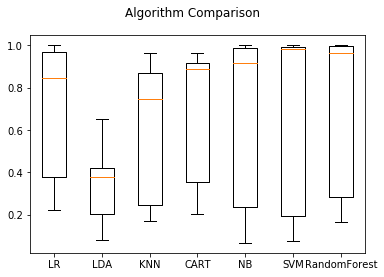

In [149]:
# Boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()